## Differentially expressed gene analysis based on measured and imputed genes

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import os

import warnings
warnings.filterwarnings("ignore")

### Differentially expressed gene analysis

In [2]:
data_dir = "data/Stereoseq_mouse_embryo"
adata_stereoseq = sc.read_h5ad(os.path.join(data_dir, "E9.5_E1S1.MOSTA.h5ad"))
adata_stereoseq.X = adata_stereoseq.layers['count']
adata_stereoseq.var_names_make_unique()

In [3]:
res_path = "examples/different_platforms_mouse-embryo/run_inspire"
adata_0 = sc.read_h5ad(res_path + "/adata_seqfish_subregions.h5ad") # containing subregion info

res_path = "Results/INSPIRE_diff_tech_embryo"
adata_imputed = sc.read_h5ad(res_path + "/adata_seqfish_imputed.h5ad")

In [4]:
data_dir = "data/seqFISH_mouse_embryo"
counts = pd.read_csv(data_dir+"/counts.csv", index_col=0)
metadata = pd.read_csv(data_dir+"/metadata.csv", index_col=0)
metadata = metadata.loc[counts.index, :]
adata_seqfish = ad.AnnData(np.array(counts.values))
adata_seqfish.var.index = counts.columns
adata_seqfish.obs = metadata
adata_seqfish = adata_seqfish[adata_seqfish.obs["embryo"] == "embryo2", ]
adata_seqfish = adata_seqfish[adata_seqfish.obs["celltype_mapped_refined"] != "Low quality", ]
adata_seqfish.obsm["spatial"] = np.array(adata_seqfish.obs[["x_global", "y_global"]])
adata_seqfish.var_names_make_unique()

adata_raw = adata_seqfish.copy()
adata_raw.obs.index = adata_raw.obs.index + "-0"
adata_raw = adata_raw[adata_0.obs.index, :]
adata_imputed = adata_imputed[adata_0.obs.index, :]
adata_imputed.obsm["spatial"] = adata_raw.obsm["spatial"]

In [5]:
cnt = np.concatenate((adata_raw.X, adata_imputed.X), axis=1)
adata = ad.AnnData(cnt)
adata.var.index = list(adata_raw.var.index) + list(adata_imputed.var.index)
adata.obs = adata_0.obs
adata.obsm["spatial"] = adata_raw.obsm["spatial"]

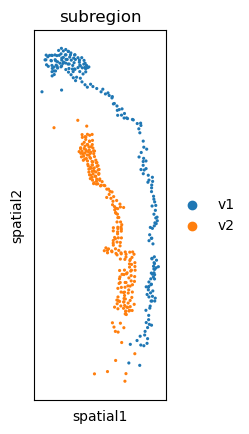

In [6]:
sc.pl.spatial(adata, color="subregion", spot_size=1.)

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [8]:
ad_v1 = adata[adata.obs["subregion"] == "v1", :].copy()
ad_v2 = adata[adata.obs["subregion"] == "v2", :].copy()
sc.pp.filter_genes(ad_v1, min_cells=10)
sc.pp.filter_genes(ad_v2, min_cells=10)
gene_keep = sorted(list(ad_v1.var.index & ad_v2.var.index))
adata = adata[:, gene_keep]

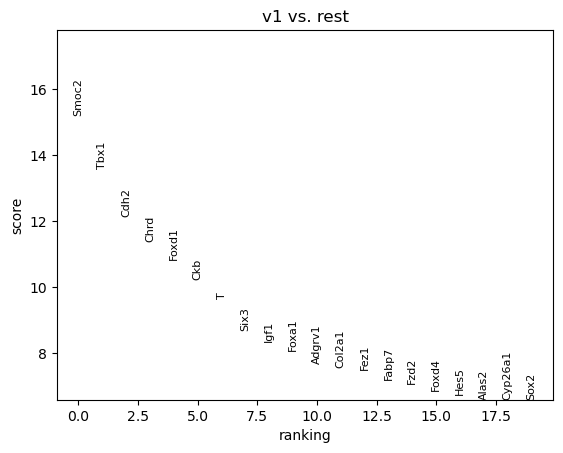

In [9]:
sc.tl.rank_genes_groups(adata, groupby="subregion", groups=['v1'], method='t-test')
sc.pl.rank_genes_groups(adata, groups=['v1'], n_genes=20)
result = adata.uns["rank_genes_groups"]
groups = result['names'].dtype.names
df_genes_v1 = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})

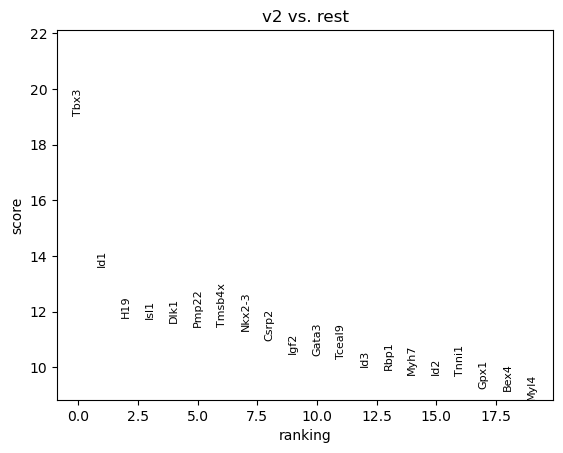

In [10]:
sc.tl.rank_genes_groups(adata, groupby="subregion", groups=['v2'], method='t-test')
sc.pl.rank_genes_groups(adata, groups=['v2'], n_genes=20)
result = adata.uns["rank_genes_groups"]
groups = result['names'].dtype.names
df_genes_v2 = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})

In [11]:
# v1 genes to highlight
v1_hl = df_genes_v1.loc[(-np.log10(df_genes_v1['v1_pvals_adj']) > 20) & (df_genes_v1['v1_logfoldchanges'] > 2), :]
print(v1_hl)
v1_hl_genes = v1_hl["v1_names"]
v1_shared = v1_hl_genes[(v1_hl_genes).isin(adata_raw.var.index)]
v1_imputed = v1_hl_genes[~(v1_hl_genes).isin(adata_raw.var.index)]
v1_shared, v1_imputed

  v1_names  v1_scores  v1_pvals_adj  v1_logfoldchanges
0    Smoc2  15.201259  2.708410e-39           3.396252
1     Tbx1  13.599668  4.535824e-33           3.065420
2     Cdh2  12.125660  6.817801e-27           2.862385
3     Chrd  11.377958  5.755430e-24           3.097420
4    Foxd1  10.829616  1.755165e-22           2.790131


(0    Smoc2
 1     Tbx1
 2     Cdh2
 3     Chrd
 Name: v1_names, dtype: object,
 4    Foxd1
 Name: v1_names, dtype: object)

In [12]:
# v2 genes to highlight
v2_hl = df_genes_v2.loc[(-np.log10(df_genes_v2['v2_pvals_adj']) > 20) & (df_genes_v2['v2_logfoldchanges'] > 2), :]
print(v2_hl)
v2_hl_genes = v2_hl["v2_names"]
v2_shared = v2_hl_genes[(v2_hl_genes).isin(adata_raw.var.index)]
v2_imputed = v2_hl_genes[~(v2_hl_genes).isin(adata_raw.var.index)]
v2_shared, v2_imputed

   v2_names  v2_scores  v2_pvals_adj  v2_logfoldchanges
0      Tbx3  19.051298  1.267464e-56           3.990730
1       Id1  13.621714  6.007180e-33           2.568959
3      Isl1  11.733144  7.267231e-26           2.543603
4      Dlk1  11.619688  2.044953e-25           2.970751
5     Pmp22  11.475699  5.665574e-25           2.871189
7    Nkx2-3  11.325468  2.118928e-24           2.612700
10    Gata3  10.430216  2.997397e-21           2.326385


(0       Tbx3
 3       Isl1
 4       Dlk1
 7     Nkx2-3
 10     Gata3
 Name: v2_names, dtype: object,
 1      Id1
 5    Pmp22
 Name: v2_names, dtype: object)

### Visualize the results

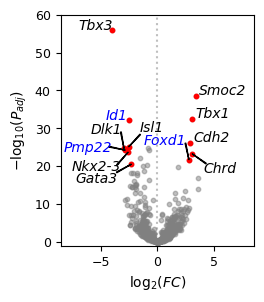

In [13]:
f = plt.figure(figsize=(2.5,3))
df_genes_v1 = df_genes_v1.loc[df_genes_v1['v1_logfoldchanges'] > 0, :]
df_genes_v2 = df_genes_v2.loc[df_genes_v2['v2_logfoldchanges'] > 0, :]


ax = f.add_subplot(1,1,1)
ax.scatter(df_genes_v1['v1_logfoldchanges'], -np.log10(df_genes_v1['v1_pvals_adj']), 
            s=10, c="gray", alpha=0.5, rasterized=True)
ax.scatter(-df_genes_v2['v2_logfoldchanges'], -np.log10(df_genes_v2['v2_pvals_adj']), 
            s=10, c="gray", alpha=0.5, rasterized=True)

# v1
for i, txt in enumerate(v1_shared):
    x = v1_hl["v1_logfoldchanges"][v1_hl["v1_names"] == txt].values
    y = -np.log10(v1_hl["v1_pvals_adj"][v1_hl["v1_names"] == txt].values)
    ax.scatter(x, y, s=10, c="red", alpha=1, rasterized=True)
    if txt == "Chrd":
        x_new = x+1
        y_new = y-5
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic",
                    arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))
    else:
        x_new = x+0.3
        y_new = y+0.4
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic")
for i, txt in enumerate(v1_imputed):
    x = v1_hl["v1_logfoldchanges"][v1_hl["v1_names"] == txt].values
    y = -np.log10(v1_hl["v1_pvals_adj"][v1_hl["v1_names"] == txt].values)
    x_new = x-4
    y_new = y+4
    ax.scatter(x, y, s=10, c="red", alpha=1, rasterized=True)
    ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "blue", fontsize=10, style = "italic",
                arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))

# v2
for i, txt in enumerate(v2_shared):
    x = -v2_hl["v2_logfoldchanges"][v2_hl["v2_names"] == txt].values
    y = -np.log10(v2_hl["v2_pvals_adj"][v2_hl["v2_names"] == txt].values)
    ax.scatter(x, y, s=10, c="red", alpha=1, rasterized=True)
    if txt == "Isl1":
        x_new = x+1
        y_new = y+4
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic",
                    arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))
    elif txt == "Dlk1":
        x_new = x-3
        y_new = y+4
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic",
                    arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))
    elif txt == "Nkx2-3":
        x_new = x-5
        y_new = y-5
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic",
                    arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))
    elif txt == "Gata3":
        x_new = x-5
        y_new = y-5
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic",
                    arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))
    else:
        x_new = x-3
        y_new = y+0.1
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "black", fontsize=10, style = "italic")
for i, txt in enumerate(v2_imputed):
    x = -v2_hl["v2_logfoldchanges"][v2_hl["v2_names"] == txt].values
    y = -np.log10(v2_hl["v2_pvals_adj"][v2_hl["v2_names"] == txt].values)
    ax.scatter(x, y, s=10, c="red", alpha=1, rasterized=True)
    if txt == "Pmp22":
        x_new = x-5.5
        y_new = y-0.3
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "blue", fontsize=10, style = "italic",
                    arrowprops=dict(facecolor='black', width=0.5, headwidth=0.5))
    else:
        x_new = x-2
        y_new = y+0.1
        ax.annotate(txt, (x, y), xytext=(x_new, y_new), color = "blue", fontsize=10, style = "italic")
plt.axvline(x=0, color="gray", alpha=0.5, ls=":")

plt.xlim(-8.6,8.6)
plt.ylim(-1,60)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("$\log_2(FC)$", fontsize=10)
plt.ylabel("$-\log_{10}(P_{adj})$", fontsize=10)
plt.show()

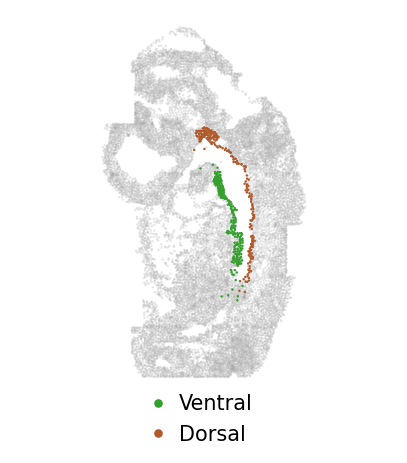

In [14]:
res_path = "examples/different_platforms_mouse-embryo/run_inspire"
adata_full = sc.read_h5ad(res_path + "/adata_ours.h5ad")
adata_plot = adata_full[adata_full.obs.slice.values.astype(str) == "0", :]

size = 3
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
ax.scatter(adata_plot.obsm["spatial"][:, 0], 
           -adata_plot.obsm["spatial"][:, 1], 
           s=size, facecolors="gray", alpha=0.2, edgecolors='none', rasterized=True)

v1_idx = adata_0[adata_0.obs.subregion.values.astype(str) == "v1", :].obs.index
ax.scatter(adata_plot[v1_idx, :].obsm["spatial"][:, 0], 
           -adata_plot[v1_idx, :].obsm["spatial"][:, 1], 
           s=size, facecolors="#B15928", alpha=1, edgecolors='none', rasterized=True, label="Dorsal")

v2_idx = adata_0[adata_0.obs.subregion.values.astype(str) == "v2", :].obs.index
ax.scatter(adata_plot[v2_idx, :].obsm["spatial"][:, 0], 
           -adata_plot[v2_idx, :].obsm["spatial"][:, 1], 
           s=size, facecolors="#33A02C", alpha=1, edgecolors='none', rasterized=True, label="Ventral")

legend_elements_slice = [Line2D([0], [0], marker='o', color="w", label='Ventral', markerfacecolor="#33A02C", markersize=8),
                         Line2D([0], [0], marker='o', color="w", label='Dorsal', markerfacecolor="#B15928", markersize=8)]
ax.legend(handles=legend_elements_slice, loc="upper left", bbox_to_anchor=(0.28, 0.05), frameon=False, 
          markerscale=.9, fontsize=15, handletextpad=0.)

ax.set_axis_off()
f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

In [15]:
adata_imputed = sc.read_h5ad(res_path + "/adata_seqfish_imputed.h5ad")
adata_raw = adata_seqfish.copy()
adata_raw.obs.index = adata_raw.obs.index + "-0"
adata_raw = adata_raw[adata_imputed.obs.index, :]
adata_imputed.obsm["spatial"] = adata_raw.obsm["spatial"]

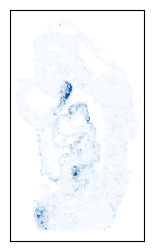

In [16]:
g = "Tbx3"

fig = plt.figure(figsize=(2,3))
size = .2

ax0 = fig.add_subplot(1,1,1)
ax0.set_aspect('equal')
x_coor = adata_raw.obsm["spatial"][:, 0]
y_coor = adata_raw.obsm["spatial"][:, 1]
im1 = ax0.scatter(x_coor, -y_coor, s=size, rasterized=True, c=np.array(adata_raw[:,g].X).reshape(-1), cmap="Blues", vmax=20)
ax0.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)


fig.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()

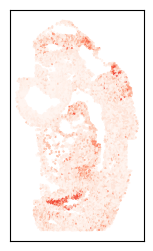

In [17]:
g = "Id1"

fig = plt.figure(figsize=(2,3))
size = .2

ax0 = fig.add_subplot(1,1,1)
ax0.set_aspect('equal')
x_coor = adata_imputed.obsm["spatial"][:, 0]
y_coor = adata_imputed.obsm["spatial"][:, 1]
im1 = ax0.scatter(x_coor, -y_coor, s=size, rasterized=True, c=np.array(adata_imputed[:,g].X).reshape(-1), cmap="Reds", vmax=32)
ax0.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)


fig.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()